# YOLO

In [1]:
import chainer
import numpy as np
import os
import pickle
import collections

## 訓練データ

PASCAL VOC2007から作成した小さいデータセット  
・人間か犬が写っている画像200枚と、その対象のラベルと位置

In [2]:
from chainercv.chainer_experimental.datasets.sliceable import GetterDataset
from chainercv.utils import read_image

label_names = ('person', 'dog')

class VOCBboxDataset(GetterDataset):
    # データセット
    def __init__(self, use_difficult=False):
        super(VOCBboxDataset, self).__init__()

        self.data_dir = 'data/detection_data/'
        path = os.path.join(self.data_dir, 'detection_data.pkl')
        with open(path, 'rb') as f:
            self.dic = pickle.load(f)

        self.add_getter('img', self._get_image)
        self.add_getter(('bbox', 'label'), self._get_annotations)
        
        self.keys = ('img', 'bbox', 'label')

    def __len__(self):
        return len(self.dic)

    def _get_image(self, i):
        id_ = self.dic[i]['id']
        img_path = os.path.join(self.data_dir, 'JPEGImages', id_ + '.jpg')
        img = read_image(img_path, color=True)
        return img

    def _get_annotations(self, i):
        bbox, label = self.dic[i]['bbox'], self.dic[i]['label']
        return bbox, label

In [3]:
import copy
from chainercv import transforms
from PIL import Image

class Transform(object):
    # 画像や物体の位置を適する形に変換
    def __init__(self, coder, size, mean):
        self.coder = copy.copy(coder)

        self.size = size  # networkへ入力する画像サイズ
        self.mean = mean  # 画像の平均強度

    def __call__(self, in_data):
        img, bbox, label = in_data

        # 画像のリサイズとそれに伴う位置の修正
        _, H, W = img.shape
        img = np.transpose(img, (1, 2, 0))
        img = Image.fromarray(np.uint8(img))
        img = img.resize((self.size, self.size))
        img = np.asarray(img, dtype=np.float32)
        img = np.transpose(img, (2, 0, 1))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # Preparation
        img -= self.mean
        loc, label = self.coder.encode(bbox, label)

        return img, loc, label

In [4]:
class Coder():
    # ラベルや位置データ ↔ ニューラルネットワークの出力
    def __init__(self, insize, n_obj):
        self.insize = insize
        self.n_obj = n_obj
    
    def encode(self, bboxs, labels):
        # ラベルや位置データ → ニューラルネットワークの出力に適する形の教師データ
        if len(bboxs) == 0:
            return (
                np.zeros(4, dtype=np.float32),
                np.zeros(self.n_obj, dtype=np.int32)
                )
        
        # 今回は画像中で物体の領域が最も大きい物体のみを検出
        areas = []
        for bbox in bboxs:
            areas.append(bbox[2] * bbox[3])
        index = np.argmax(areas)
        
        # バウンディングボックスから(center_y, center_x, height, width)への変換
        loc = bboxs[index].copy()
        # (y_min, x_min, y_max, x_max) -> (y_min, x_min, height, width)
        loc[2:] -= loc[:2]
        # (y_min, x_min, height, width) -> (center_y, center_x, height, width)
        loc[:2] += loc[2:] * 0.5
        loc /= self.insize

        # ラベル
        label = labels[index]
        return loc.astype(np.float32), label
    
    def decode(self, loc, p, conf):
        # ニューラルネットワークの出力 → 位置、ラベル、スコア
        # encodeの逆
        loc[:2] -= loc[2:] * 0.5
        loc[2:] += loc[:2]
        loc *= self.insize

        bbox = loc.astype(np.float32)
        label = np.argmax(p)
        # スコア = 対象物体の確率×バウンディングボックスの信頼度
        score = p[label] * conf

        return bbox, label, score

In [5]:
from chainer.datasets import TransformDataset

insize = 56
mean = np.array((123, 117, 104)).reshape((-1, 1, 1))

# イテレータを作成
coder = Coder(insize, 2)
train = TransformDataset(
    VOCBboxDataset(),
    Transform(coder, insize, mean))
train_iter = chainer.iterators.SerialIterator(train, batch_size=64)

### データの可視化（真）

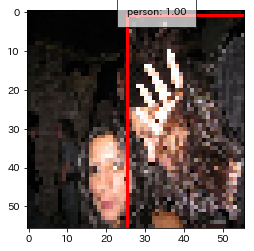

In [6]:
from chainercv.visualizations import vis_bbox
import matplotlib.pyplot as plt
% matplotlib inline

sample = train_iter.next()[0]
img, loc, label = sample
p =[0., 0.]
p[label] = 1.
bbox, label, score = coder.decode(loc, p, 1.)

vis_bbox(
    img+mean, [bbox], [label], [score], label_names=label_names)

## モデル

サイズの小さいYOLO

YOLOの前半の層は分類タスクによって事前学習する（学習の安定化のため）ので、ベースとなる部分とそれ以降の部分に分ける。

In [7]:
from chainer import functions as F
from chainer import initializers
from chainer import links as L

class BaseNet(chainer.Chain):
    # 分類器とYOLOで重みをシェアする部分
    def  __init__(self):
        super(BaseNet, self).__init__()
        # 重みの初期値
        init = {
            'initialW': initializers.Normal(0.01),
            'initial_bias': initializers.Zero(),
            }
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 64, ksize=3, stride=2, pad=1, **init)
            self.bn1 = L.BatchNormalization(64)
            
            self.conv2_1 = L.Convolution2D(64, 192, ksize=3, stride=1, pad=1, **init)
            self.conv2_2 = L.Convolution2D(192, 192, ksize=3, stride=1, pad=1, **init)
            self.bn2 = L.BatchNormalization(192)
            
            self.fc = L.Linear(192 * 7 * 7, 512, **init)
        
        self.functions = self.orderd_functions()
    
    def __call__(self, x):
        h = x
        for key, funcs in self.functions.items():
            for func in funcs:
                h = func(h)
        return h
    
    def orderd_functions(self):
        return collections.OrderedDict([                            # size: 56
            ('conv1',    [self.conv1, _leaky_relu, self.bn1]),      # size: 28
            ('pool1',     [_max_pooling_2d]),                           # size: 14
            
            ('conv2_1', [self.conv2_1, _leaky_relu]),
            ('conv2_2', [self.conv2_2, _leaky_relu, self.bn2]),
            ('pool2',     [_max_pooling_2d]),                            # size: 7
            
            ('fc',        [self.fc, _leaky_relu]),
        ])
    
def _max_pooling_2d(x):
    return F.max_pooling_2d(x, ksize=2)

def _leaky_relu(x):
    return F.leaky_relu(x, slope=0.1)

In [8]:
class PreClassifier(chainer.Chain):
    # 事前学習する分類器の出力部分
    def  __init__(self, base):
        super(PreClassifier, self).__init__()
        with self.init_scope():
            self.base = base
            self.fc1 = L.Linear(512, 512)
            self.fc2 = L.Linear(None, 2)
        
    def __call__(self, x):
        h = base(x)
        h = F.dropout(_leaky_relu(self.fc1(h)))
        return self.fc2(h)

### 事前学習

YOLOの前半の層を分類タスクによって事前学習する

In [9]:
base = BaseNet()
model = L.Classifier(PreClassifier(base))

In [10]:
optimizer = chainer.optimizers.MomentumSGD(lr=0.001)
optimizer.setup(model)

In [11]:
n_epoch = 20

while train_iter.epoch < n_epoch:
    train_batch = train_iter.next()
    x, t_loc, t_label = chainer.dataset.concat_examples(train_batch)
    loss = model(x, t_label)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    if train_iter.is_new_epoch:
        print('epoch:{:02d} loss:{:.04f} '.format(train_iter.epoch, np.float(loss.data)))

epoch:01 loss:0.8073 
epoch:02 loss:0.5150 
epoch:03 loss:0.5014 
epoch:04 loss:0.4099 
epoch:05 loss:0.2758 
epoch:06 loss:0.2504 
epoch:07 loss:0.2593 
epoch:08 loss:0.1566 
epoch:09 loss:0.1021 
epoch:10 loss:0.0794 
epoch:11 loss:0.0881 
epoch:12 loss:0.0738 
epoch:13 loss:0.0587 
epoch:14 loss:0.0367 
epoch:15 loss:0.0262 
epoch:16 loss:0.0219 
epoch:17 loss:0.0239 
epoch:18 loss:0.0217 
epoch:19 loss:0.0193 
epoch:20 loss:0.0110 


### YOLOの後半部分

In [12]:
from chainer import reporter

class YOLO(chainer.Chain):
    # YOLOの出力部分
    def  __init__(self, base):
        super(YOLO, self).__init__()
        
        with self.init_scope():
            self.base = base
            self.fc1 = L.Linear(512, 512)
            self.fc2 = L.Linear(None, 1*1*7)
        
    def predictor(self, x):
        h = self.base(x)
        h = F.dropout(_leaky_relu(self.fc1(h)))
        return self.fc2(h)
    
    def __call__(self, x, *t):
        t_loc, t_label = t
        output = self.predictor(x)
        batch_size = output.shape[0]
        
        x, y, w, h, conf, prob = interpret(output)
        tx, ty, tw, th = np.split(t_loc.astype(np.float32), [1, 2, 3], axis=1)
        I = np.eye(2, dtype=np.float32)
        tprob = I[t_label]
        tconf = iou(x, y, w, h, tx, ty, tw, th)
        loss = _loss(x, y, w, h, conf, prob,
                                tx, ty, tw, th, tprob, tconf)
        reporter.report({'loss': loss}, self)
        return loss
    

def _loss(x, y, w, h, conf, prob,
             tx, ty, tw, th, tprob, tconf, l_box=5., l_conf=0.5):  # すべてobj
    # YOLOの損失関数
    x_loss = F.sum((tx - x) ** 2) / 2
    y_loss = F.sum((ty - y) ** 2) / 2
#     w_loss = F.sum((tw - w) ** 2) / 2
#     h_loss = F.sum((th - h) ** 2) / 2
    w_loss = F.sum((F.sqrt(tw) - F.sqrt(w)) ** 2) / 2
    h_loss = F.sum((F.sqrt(th) - F.sqrt(h)) ** 2) / 2
    c_loss = F.sum((tconf - conf) ** 2) / 2
    p_loss = F.sum((tprob - prob) ** 2) / 2
    return l_box*(x_loss + y_loss + w_loss + h_loss) + l_conf*c_loss + p_loss


def interpret(output):
    # YOLOの出力をバウンディングボックスの位置やサイズ、信頼度、
    # 物体クラスの確率と解釈可能な形に変換
    x, y, w, h, conf, prob = F.split_axis(output, (1, 2, 3, 4, 5), axis=1)
    x = F.sigmoid(x)
    y = F.sigmoid(y)
    w = F.sigmoid(w)
    h = F.sigmoid(h)
    conf = F.sigmoid(conf)
    prob = F.softmax(prob)
    return x, y, w, h, conf, prob


def iou(x, y, w, h, tx, ty, tw, th):
    # IOU = 2つのバウンディングボックスの共通面積 / 連結した2つのバウンディングボックスの総面積
    width = overlap(x, w, tx, tw)
    height = overlap(y, h, ty, th)
    intersection = width * height
    union = w*h + tw*th - intersection
    return intersection / union
    

def overlap(x1, len1, x2, len2):
    # 共通部分
    len1_half = len1/2
    len2_half = len2/2
    
    left = F.maximum(x1 - len1_half, x2 - len2_half)
    right = F.minimum(x1 + len1_half, x2 + len2_half)

    return right - left

## 学習

In [13]:
yolo = YOLO(base)
optimizer = chainer.optimizers.MomentumSGD(lr=1e-6)
optimizer.setup(yolo)

In [14]:
from chainer import training
from chainer.training import extensions

# trainer設定
train_iter = chainer.iterators.SerialIterator(train, batch_size=64)
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, stop_trigger=(30, 'epoch'), out='result')
# 出力設定
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']))

In [15]:
# 実行
trainer.run()

epoch       iteration   main/loss 
1           4           92.7416     
2           7           85.6492     
3           10          77.7445     
4           13          74.1976     
5           16          67.3723     
6           19          63.0742     
7           22          60.1407     
8           25          55.0126     
9           29          52.8334     
10          32          48.0104     
11          35          48.4192     
12          38          46.3837     
13          41          46.3883     
14          44          46.2929     
15          47          43.7514     
16          50          43.2385     
17          54          42.0067     
18          57          41.7856     
19          60          42.7708     
20          63          44.314      
21          66          34.9482     
22          69          36.272      
23          72          34.2021     
24          75          34.7912     
25          79          33.9796     
26          82          34.1324     
27 

In [16]:
# trainer使わないversion

# n_epoch = 50
# while train_iter.epoch < n_epoch:
#     train_batch = train_iter.next()
#     x, t_loc, t_label, t_obj = chainer.dataset.concat_examples(train_batch)
#     loss = yolo(x, t_loc, t_label, t_obj)
#     yolo.cleargrads()
#     loss.backward()
#     optimizer.update()
#     if train_iter.is_new_epoch:
#         print('epoch:{:02d} loss:{:.04f} '.format(train_iter.epoch, np.float(loss.data)))

## 結果の可視化

簡単のため訓練データに対して実際に学習できているか確認する。
（精度の検証などをするときは検証データやテストデータを別途用意して検証する）

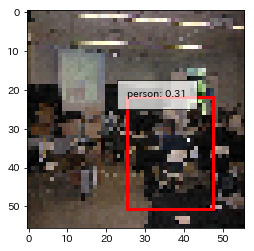

In [17]:
sample = train_iter.next()[0]
img, loc, label = sample
chainer.config.train=False
x, y, w, h, conf, prob = interpret(yolo.predictor(np.array([img])))

loc = np.array([x.data, y.data, w.data, h.data]).ravel()
bbox, label, score = coder.decode(loc, prob.data.ravel(), conf.data.ravel()[0])
vis_bbox(
    img+mean, [bbox], [label], [score], label_names=label_names)